# 模擬資料

In [1]:
import numpy as np
import pandas as pd
import scipy
import random
from scipy.stats import poisson,uniform
import matplotlib.pyplot as plt
from PIL import Image as im
import tensorflow as tf
from tensorflow import keras

## 參數設定

In [2]:
kernel_value = np.array([3, 3])
image_size = np.array([10, 10])

## 函數

In [3]:
def Simulate_Image(n, img_h=10, img_w=10, pat_shape=np.ones((3,3))):
    Pat_h = pat_shape.shape[0]; Pat_w = pat_shape.shape[1] 
    W = np.random.random((n, img_h, img_w))
    Y_num = np.random.poisson(lam = 0.72, size = n)
    for i in np.arange(n) :
        if Y_num[i] > 0 :
            Y_i = np.random.choice(np.arange(img_h-Pat_h+1), Y_num[i]).astype(int)   
            Y_j = np.random.choice(np.arange(img_h-Pat_w+1), Y_num[i]).astype(int)
            for k in np.arange(Y_num[i]) :
                r_p = pat_shape * random.uniform(0,1)
                W[i, Y_i[k]:Y_i[k]+3, Y_j[k]:Y_j[k]+3] = r_p
            else :
                None
                
    categorized_list = np.empty((0, 0))
    for num in Y_num:
        if num > 0:
            categorized_list = np.append(categorized_list, 1)
        else:
            categorized_list = np.append(categorized_list, 0)

    L = {'image' : W, 'label' : categorized_list}
    return(L)

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(10, 10, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(10, 10, 1)),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2)
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 64)          640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 64)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
Total params: 2,690
Trainable params: 2,690
Non-trainable params: 0
_________________________________________________________________


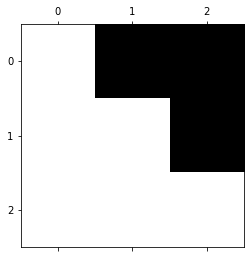

In [23]:
plt.matshow(np.matrix([[1,0,0], [1,1,0] ,[1,1,1]]))

In [30]:
Acc_matrix = np.zeros(100)
pattern = np.matrix([[1,0,0], [1,1,0] ,[1,1,1]])

for i in np.arange(1):
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(10, 10, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(10, 10, 1)),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2)
    ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    train, test = Simulate_Image(1000, pat_shape = pattern), Simulate_Image(500, pat_shape = pattern)
    train_images, train_labels = train['image'], train['label']
    test_images, test_labels = test['image'], test['label'] 

    history = model.fit(train_images, train_labels, epochs=10, 
                        validation_data=(test_images, test_labels),
                        verbose = 0)
    
    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
    Acc_matrix[i] = test_acc
    

16/16 - 0s - loss: 0.5573 - accuracy: 0.7100 - 43ms/epoch - 3ms/step


In [6]:
print(Acc_matrix.mean().round(4))
# np.savetxt('sim_classic_acc.txt', Acc_matrix, fmt='%d')

0.0087


16/16 - 0s - loss: 0.3680 - accuracy: 0.8660 - 47ms/epoch - 3ms/step


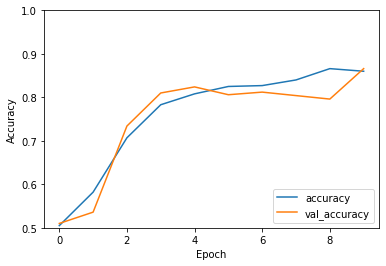

In [7]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
model.save('simulate_model.h5')

# HeatMap

In [8]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(1,2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

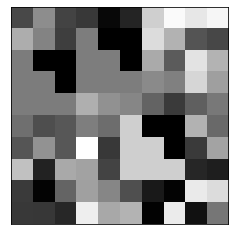

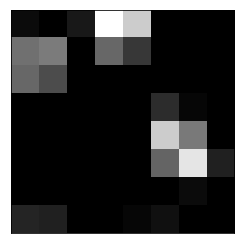

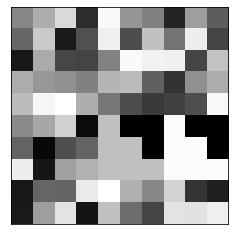

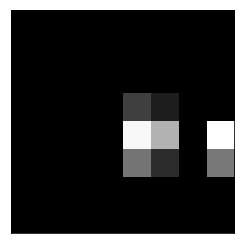

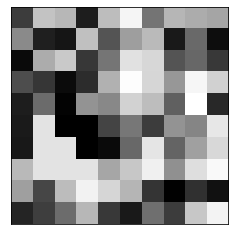

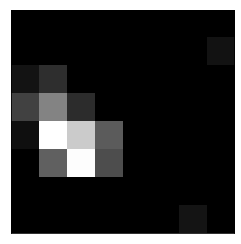

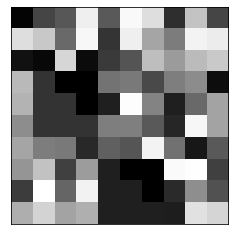

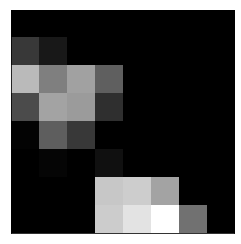

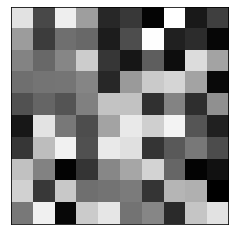

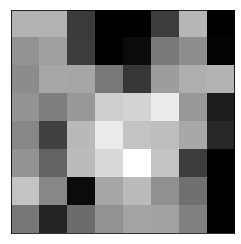

In [31]:
j = 0
while j < 5 :
    test_labels_pos = np.where(test_labels[test_labels == 1])
    test_labels_select = np.random.choice(test_labels_pos[0], 1)

    model.layers[-1].activation = None
    last_conv_layer_name = "conv2d_7"
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(np.expand_dims(train_images[test_labels_select,:,:], axis=3), 
                                model, 
                                last_conv_layer_name)

    # print(train_images[test_labels_select,:,:].round(2))

    plt.gray()
    plt.imshow(train_images[int(test_labels_select),:,:], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.matshow(heatmap)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    j = j + 1